In [1]:
import pickle

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import numpy as np; np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt

from plot_module import plot_ODE, plot_gillespie, plot_simulator_graph, plot_neuron_graph
from sim_param_from_network import names_from_network, gillespie_param_from_network, dataframes_from_network, ODE_from_network
from network_generate import net_gen_line_chain, net_gen_line_ring, net_gen_line_powlawtree, net_gen_hub_ring
from neuron_graph_transform import neuron_graph_transform, add_bioparam_attributes

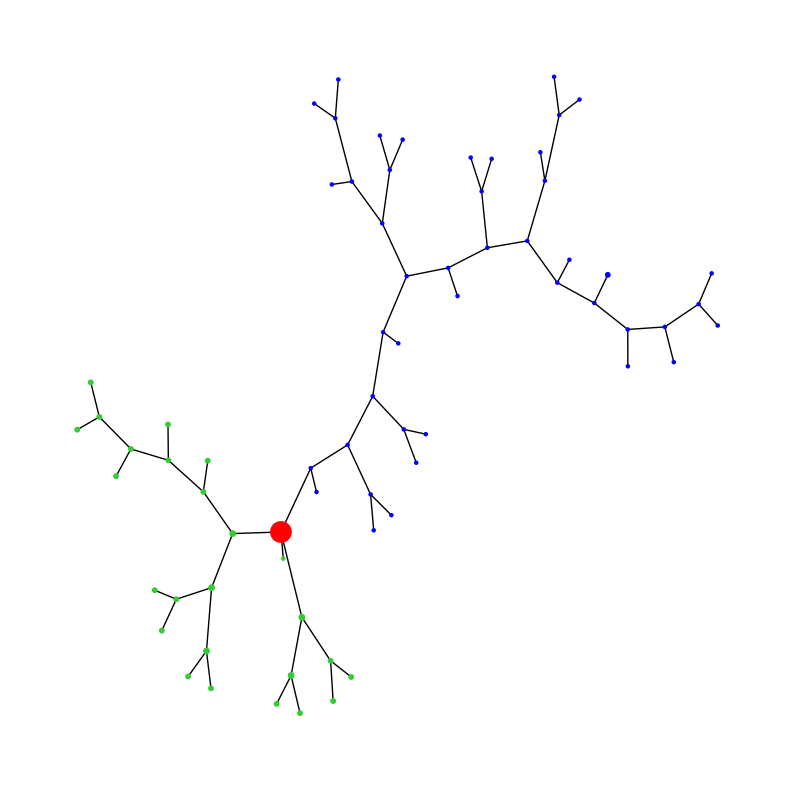

In [2]:
neuron_filename = 'test_nx_neurgraph.pkl'
with open(f'neuron_shape_data/{neuron_filename}', 'rb') as f:
    G = pickle.load(f)    

plot_neuron_graph(G)

> The undirected input graph has 71 nodes, and 70 edges, and 4 subgraph(s):
'axon with 45 nodes', 'dendrite with 1 nodes', 'dendrite with 17 nodes', 'dendrite with 7 nodes'
> the directed output graph has 74 nodes, and 148 edges


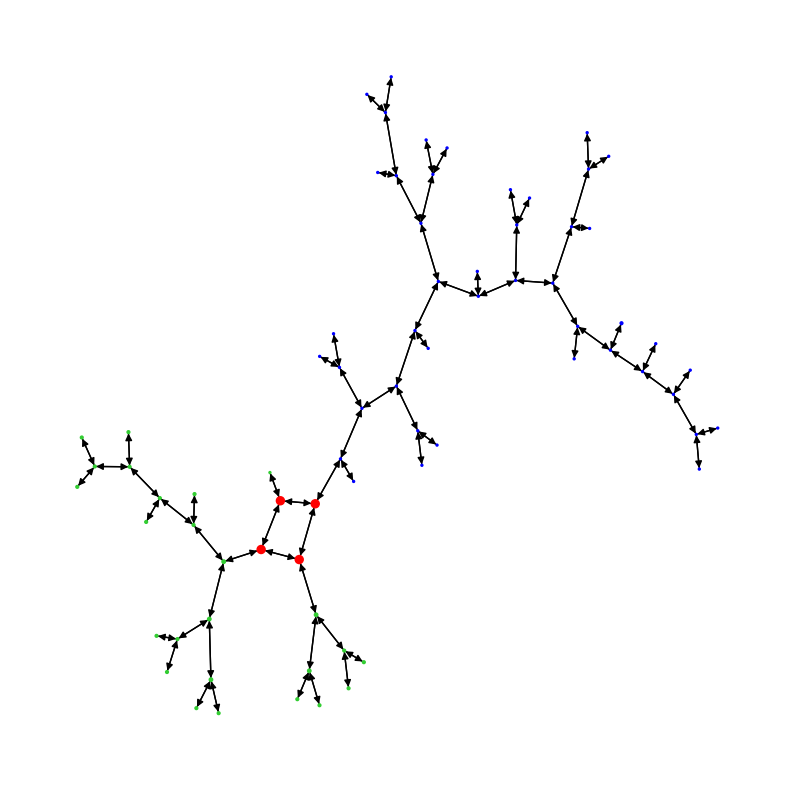

In [5]:
neuron_graph = neuron_graph_transform(G, transform_type='bidirect', n_soma_nodes=4)

plot_neuron_graph(neuron_graph)

In [8]:
SOMA_CB = 0.5
SOMA_BR = 0.4
SOMA_NSS = 100
SOMA_DIFFUSION = 0.4

DELTA = 0.5
DEATH_RATE = 0.4

AXON_TRNSP_ANT = 8
AXON_TRNSP_RET = 6

REVERSAL_RATE = 0.001

BIO_PARAM = {
    'soma_cb':SOMA_CB, 
    'soma_br':SOMA_BR, 
    'soma_nss':SOMA_NSS,
    'soma_diffusion':SOMA_DIFFUSION,
    
    'delta':DELTA, 
    'death_rate':DEATH_RATE, 
    
    'gamma_ant':AXON_TRNSP_ANT,
    'gamma_ret':AXON_TRNSP_RET,
    
    'reversal_rate':REVERSAL_RATE,
    }

neruon_graph = add_bioparam_attributes(neuron_graph, BIO_PARAM)

for u, v, data in neuron_graph.edges(data = True): print(f'{u}-{v}: {data}')
for node, data in neuron_graph.nodes(data = True): print(f'{node}: {data}')

S0-S1: {'edgetype': 1, 'rate': 0.4}
S0-S3: {'edgetype': 1, 'rate': 0.4}
S0-8: {'edgetype': 2, 'direction': 'forward', 'rate': 8.0}
S1-S0: {'edgetype': 1, 'rate': 0.4}
S1-S2: {'edgetype': 1, 'rate': 0.4}
S1-509: {'edgetype': 3, 'direction': 'forward', 'rate': 8.0}
S2-S1: {'edgetype': 1, 'rate': 0.4}
S2-S3: {'edgetype': 1, 'rate': 0.4}
S2-512: {'edgetype': 3, 'direction': 'forward', 'rate': 8.0}
S3-S0: {'edgetype': 1, 'rate': 0.4}
S3-S2: {'edgetype': 1, 'rate': 0.4}
S3-956: {'edgetype': 3, 'direction': 'forward', 'rate': 8.0}
8-39: {'volume': 3.8802, 'len': 85.7713, 'edgetype': 2, 'direction': 'forward', 'rate': 8.0}
8-501: {'volume': 0.8409, 'len': 18.5869, 'edgetype': 2, 'direction': 'forward', 'rate': 8.0}
8-S0: {'edgetype': 2, 'direction': 'reverse', 'rate': 6.0}
39-8: {'volume': 3.8802, 'len': 85.7713, 'edgetype': 2, 'direction': 'reverse', 'rate': 6.0}
39-55: {'volume': 1.9385, 'len': 42.8493, 'edgetype': 2, 'direction': 'forward', 'rate': 8.0}
39-467: {'volume': 0.2687, 'len': 5.9